In [1]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path


In [2]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

# Events
earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

In [3]:
# earthquakes


In [4]:
weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes.iloc[[11,12,13]]
    
one_at_a_time = False
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

# Stations

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_3COMP_newdetrend.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR


In [5]:
dist_array.shape


(439, 10)

In [9]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path_to_files + '3comp_newdetrend_mcmc_arrays/mcmc_results_summary.csv')
mcmc_results_array = mcmc_results.values

counter = 0
results = []
errors = []
diffs = []

for idx in range(len(mcmc_results_array)):
    
    eq_id = str(mcmc_results_array[idx,0])
    sta = str(mcmc_results_array[idx,2])
    hypdist = int(mcmc_results_array[idx,3])

    # print(eq_id, sta, hypdist)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
    xlow = 10
    xhigh = get_xhigh(eq_id)
    
    try:
        # Read in data - peak strain data only has the ones with SNR > 2
        pst = read(path_to_files + 'strain_data/3comp_peak_post_p_newdetrend/' + eq_id + '/' + sta + '.mseed')
        counter += 1
        # pst.plot()
        # plt.plot(pst[0].times(), pst[0].data)
        # plt.semilogy()
        # plt.show()

    except:
        continue # Skips to next row in dist_array/next station

    times = pst[0].times()
    data = pst[0].data
    log10_data = np.log10(data)
    samp_rate = pst[0].stats.sampling_rate
    
    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)

    xobserved = times[vec_start:vec_end]
    yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]
    
    m1_slope = float(mcmc_results_array[idx,5])
    m2_slope = float(mcmc_results_array[idx,6])
    int_time = float(mcmc_results_array[idx,7])
    
    diff = m1_slope - m2_slope
    diffs.append(diff)
    
    int_x_samp = int(int_time*samp_rate)
    
    # mx + b for the lines
    
    b1 = y0 - m1_slope*x0
    b2 = m1_slope*int_time + b1 - m2_slope*int_time
    
    line1_xobs = times[vec_start:int_x_samp]
    line1_ymodel = m1_slope * line1_xobs + b1
    line1_yobs = log10_data[vec_start:int_x_samp]
    
    line2_xobs = times[int_x_samp:vec_end]
    line2_ymodel = m2_slope * line2_xobs + b2
    line2_yobs = log10_data[int_x_samp:vec_end]
    
    xobs = np.append(line1_xobs, line2_xobs)
    ymodel = np.append(line1_ymodel, line2_ymodel)
    yobs = np.append(line1_yobs, line2_yobs)
    
    error_line1 = np.sqrt(np.sum(np.square(np.subtract(line1_ymodel, line1_yobs))))
    error_line2 = np.sqrt(np.sum(np.square(np.subtract(line2_ymodel, line2_yobs))))
    
    error = np.sqrt(np.sum(np.square(np.subtract(ymodel, yobs))))
    errors.append(error)
    # print(error)
    
    # if error <= 5 and m1_slope > m2_slope and int_time <= 15:
    # if error <= 5 and m1_slope > m2_slope:
    # if diff > 0.1 and error_line1 < 5 and error_line2 < 10:
    if diff > 0 and error_line1 < 3.5 and error_line2 < 6.5:
        results.append('g')
        # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + '\ndiff: ' + str(round(diff,3)) + ', M2 slope: ' + str(round(m2_slope,4)))
        # plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
        # plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
        # plt.legend()
        # plt.show()
    else:
        results.append('b')
        # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + ', diff: ' + str(round(diff,3)))
        # # plt.title('Line 1 error: ' + str(round(error_line1,3)) + ', line 2 error: ' + str(round(error_line2,3)) + '\ndiff: ' + str(round(diff,3)) + ', M2 slope: ' + str(round(m2_slope,4)))
        # plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
        # plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
        # plt.legend()
        # plt.show()
    
    # if error_line1 >= 1 and diff <= 0.1:
    #     plt.title('Line 1 error = ' + str(round(error_line1,1)))
    #     plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
    #     plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
    #     plt.legend()
        # plt.show()

mcmc_results['two_line_fit_qual'] = results
mcmc_results.to_csv(path_to_files + '3comp_newdetrend_mcmc_arrays/mcmc_results_summary_with_quality.csv', index = False) 
good_results = mcmc_results[mcmc_results['two_line_fit_qual'] == 'g']
bad_results = mcmc_results[mcmc_results['two_line_fit_qual'] == 'b']

In [10]:
bad_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time,two_line_fit_qual
13,2022-12-20_M6.4,6.4,B040,221,20,2.823870,0.058487,10.825905,0.196989,10.9,b
15,2022-12-20_M6.4,6.4,B054,352,20,0.557532,0.060143,12.120628,0.082492,12.2,b
20,2022-11-22_M6.2,6.2,B081,324,25,1.747838,0.040301,11.756877,0.068902,11.8,b
27,2021-12-20_M6.2,6.2,B033,336,60,0.175467,0.005720,21.556544,0.138538,21.6,b
28,2021-12-20_M6.2,6.2,B035,246,60,0.664268,0.026680,13.239407,0.282542,13.3,b
29,2021-12-20_M6.2,6.2,B036,247,60,0.219511,0.006155,20.749882,0.189275,20.8,b
30,2021-12-20_M6.2,6.2,B039,193,60,2.966655,0.029194,10.934153,0.130857,11.0,b
31,2021-12-20_M6.2,6.2,B040,224,60,2.083335,0.024701,11.207599,0.183912,11.3,b
32,2021-12-20_M6.2,6.2,B045,26,60,0.438209,0.004593,14.026527,0.176140,14.1,b
35,2021-12-20_M6.2,6.2,B058,463,60,1.366328,0.016593,11.577349,0.214475,11.6,b


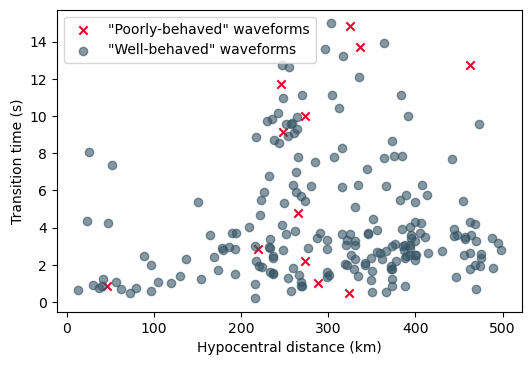

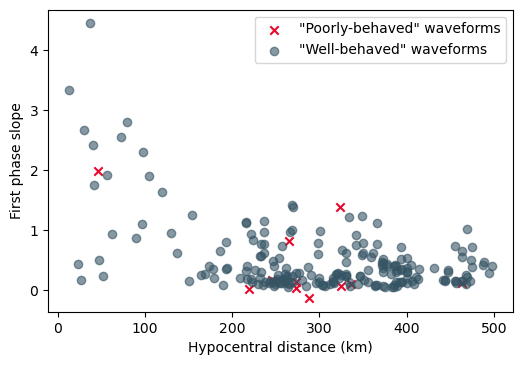

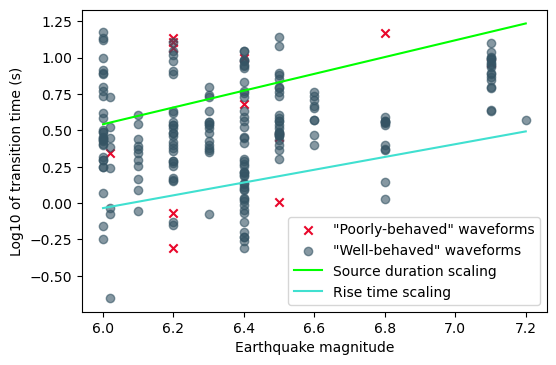

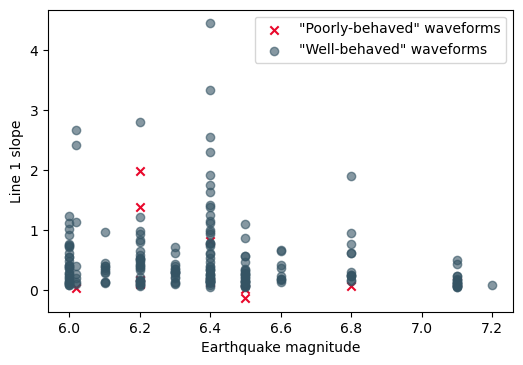

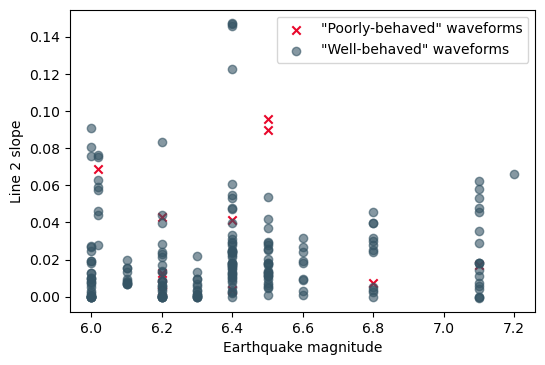

In [11]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,7.25,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)

dpi = 100

plt.figure(dpi = dpi)
plt.scatter(bad_results.hypdist.values, bad_results.xinter.values-10, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.hypdist.values, good_results.xinter.values-10, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Hypocentral distance (km)')
plt.ylabel('Transition time (s)')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_hypdist_vs_transtime.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.hypdist.values, bad_results.m1.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.hypdist.values, good_results.m1.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Hypocentral distance (km)')
plt.ylabel('First phase slope')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_hypdist_vs_transtime.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.mag.values, np.log10(bad_results.xinter.values-10), marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.mag.values, np.log10(good_results.xinter.values-10), marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_transtime.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.mag.values, bad_results.m1.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.mag.values, good_results.m1.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 1 slope')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_m1.png', format = 'PNG')
# plt.close()

plt.figure(dpi = dpi)
plt.scatter(bad_results.mag.values, bad_results.m2.values, marker = 'x', color = '#E9072B', label = '"Poorly-behaved" waveforms')
plt.scatter(good_results.mag.values, good_results.m2.values, marker = 'o', color = '#355464', alpha = 0.6, label = '"Well-behaved" waveforms')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 2 slope')
plt.legend()
plt.show()
# plt.savefig(path_to_files + 'figures/filtered_mcmc_plots/summary_mag_vs_m2.png', format = 'PNG')
# plt.close()

In [7]:
def get_xhigh(eq_id):
    
    if eq_id == '2023-04-13_M6':
        xhigh = 60
    elif eq_id == '2022-12-20_M6.4':
        if hypdist < 200:
            xhigh = 20
        else:
            xhigh = 40
    elif eq_id == '2022-11-22_M6.2': # Weird one that pauses for a while then grows again
        xhigh = 25
    elif eq_id == '2021-12-20_M6.2':
        if hypdist < 30: 
            xhigh = 20
        elif 30 < hypdist < 50:
            xhigh = 25
        elif 50 < hypdist < 100:
            xhigh = 30
        else:
            xhigh = 60
    elif eq_id == '2021-07-08_M6': # Lots of more gradual ones with pause again
        if hypdist < 300:
            xhigh = 25
        else:
            xhigh = 50
    elif eq_id == '2020-05-15_M6.5':
        xhigh = 30
    elif eq_id == '2020-03-31_M6.5':
        xhigh = 35
    elif eq_id == '2019-12-25_M6.3':
        xhigh = 35
    elif eq_id == '2019-12-23T20_M6':
        xhigh = 60
    elif eq_id == '2019-12-23T19_M6':
        xhigh = 60
    elif eq_id == '2019-08-29_M6.3': # All flatten fast
        xhigh = 60
    elif eq_id == '2019-07-06_M7.1': # Ridgecrest mainshock
        xhigh = 27
    elif eq_id == '2019-07-04_M6.4': # Ridgecrest foreshock
        if hypdist < 50:
            xhigh = 20
        else:
            xhigh = 27
    elif eq_id == '2019-07-04_M6.2':
        xhigh = 35
    # elif eq_id == '2018-10-22T06_M6.5': # No waveforms with high enough SNR
    #     xhigh = 
    elif eq_id == '2018-10-22_M6.8': # Has like 3 slopes? Letting it go long
        xhigh = 60
    elif eq_id == '2018-10-22T05_M6.5': # Somewhat of a pause but all similar? Going long
        xhigh = 60
    elif eq_id == '2018-08-22_M6.2':
        xhigh = 60
    elif eq_id == '2016-12-08_M6.6':
        xhigh = 60
    elif eq_id == '2014-08-24_M6.02':
        xhigh = 27
    elif eq_id == '2014-04-24_M6.5':
        xhigh = 50
    elif eq_id == '2014-03-10_M6.8':
        if hypdist < 110:
            xhigh = 25
        else:
            xhigh = 40
    elif eq_id == '2013-09-04_M6':
        xhigh = 25
    elif eq_id == '2013-09-03_M6.1':
        xhigh = 30
    elif eq_id == '2012-12-14_M6.3':
        xhigh = 25
    elif eq_id == '2012-11-08_M6.1':
        xhigh = 42
    elif eq_id == '2012-04-11_M6':
        xhigh = 30
    elif eq_id == '2011-09-09_M6.4':
        xhigh = 35
    elif eq_id == '2010-04-04_M7.2':
        xhigh = 35
    elif eq_id == '2010-01-10_M6.5':
        xhigh = 35
    elif eq_id == '2008-01-10_M6.3':
        xhigh = 24
    else:
        xhigh = 'no data'
    
    return xhigh
